# Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
pd.set_option('display.precision', 5)

# Data Cleaning

In [3]:
# Import Data:
Ames_HousePrice = pd.read_csv('Ames_HousePrice.csv', index_col=0)
real_coords = pd.read_csv("real_estate_with_coordinates.csv")

# One row is duplicated in Ames_HousePrice df, once dropped there are no duplicate PID values
Ames_HousePrice = Ames_HousePrice.drop_duplicates()
real_coords = real_coords.drop_duplicates()

# Dataframe merging
real_estate_columns_to_keep = ['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']
housing_coords = pd.merge(Ames_HousePrice, real_coords[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

# Remove any duplicate rows created in merge
housing_coords = housing_coords.drop_duplicates()

# Drop Columns with too many NA Values
housing_coords.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

# DistanceToISU column contains the distance of each property to Iowa State University
# Coordinates of Iowa State University
isu_latitude = 42.0239
isu_longitude = -93.6476
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    radius = 3958.8
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Calculate the distance
    distance = radius * c
    return distance
# Calculate distance for each property address
housing_coords['DistanceToISU'] = housing_coords.apply(
    lambda row: haversine(row['latitude'], row['longitude'], isu_latitude, isu_longitude), axis=1)

# Remove missing gps data rows:
housing_coords = housing_coords.dropna(subset=['latitude'])

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']
# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014

# Reset index after dropping rows so flitering by iloc works smoothly
housing_coords.reset_index(drop=True,inplace=True)

# This is good for EDA but since it is calculated from the target it will cause 
# data leakage and shouldn't be included in modeling
    # # Added PricePerSF Column
    # housing_coords['PricePerSF'] = housing_coords['SalePrice'] / housing_coords['GrLivArea']

# Delete utilities column, it has 2496/2497 with same value
    # housing_coords.Utilities.value_counts() # <-- No N/As here
housing_coords.drop('Utilities',axis=1,inplace=True)

# Fix Row with Missing Values in Basement Categories
housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
    'BsmtFullBath','BsmtHalfBath']] = housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)

# Masonry Veneer (Type/Area)
    # If Type = 'None' but Area != 0, Type updated to mode
    # N/As updated to None for Type and 0 for Area
idx = (housing_coords['MasVnrArea'].isna()) & (housing_coords['MasVnrType'].isna())
housing_coords.loc[idx, 'MasVnrArea'] = housing_coords.loc[idx, 'MasVnrArea'].fillna(0)
housing_coords.loc[idx, 'MasVnrType'] = housing_coords.loc[idx, 'MasVnrType'].fillna('None')
mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]
idx2 = (housing_coords['MasVnrArea']!=0) & (housing_coords['MasVnrType']== 'None')
housing_coords.loc[idx2, 'MasVnrType'] = housing_coords.loc[idx2, 'MasVnrType'].fillna(mode_MasVnrType)

# Fix Row with Missing Values in GarageCars & GarageArea Categories
idx3 = (housing_coords['GarageArea']!=0) & (housing_coords['GarageType']=='Detchd')
mean_GarageArea = round(housing_coords.loc[idx3, 'GarageArea'].mean())
housing_coords.loc[housing_coords.PID==910201180,'GarageArea'] = mean_GarageArea
idx4 = housing_coords['GarageType']=='Detchd'
mode_GarageCars = housing_coords.loc[idx4, 'GarageCars'].mode()[0]
housing_coords.loc[housing_coords.PID==910201180,'GarageCars'] = mode_GarageCars

# Fill GarageYrBlt to match Year House Was Built
housing_coords['GarageYrBlt'] = housing_coords['GarageYrBlt'].fillna(housing_coords['YearBuilt']) # 129 N/A

# Fix Row where Year Remodeled occured before Year Built
housing_coords.loc[housing_coords.PID==907194160,'YearRemodAdd'] = \
housing_coords.loc[housing_coords.PID==907194160,'YearBuilt']

# Fill with Most Common (Categorical) Value:
mode_Electrical = housing_coords['Electrical'].mode()[0] # 1 N/A
housing_coords['Electrical'].fillna(mode_Electrical, inplace=True)

# 451 N/A values for Lot Frontage
    # The average ratio of LotFrontage/LotArea was calculated for each
    # LotType & LotShape and this percentage factor was used to calculate
    # The missing LotFrontage Values (since LotArea was not missing)
lot_df = housing_coords.loc[housing_coords['LotFrontage'].notna()][[
    'LotFrontage','LotArea','LotConfig','LotShape']]
lot_df2 = lot_df.groupby(['LotConfig','LotShape']).agg({'LotFrontage':'mean','LotArea':'mean'})
lot_df2['PCT_Frontage']=lot_df2['LotFrontage']/lot_df2['LotArea']
percentage_factor_mapping = lot_df2['PCT_Frontage'].to_dict()

# Update the NaN values in 'LotFrontage' using the mapping and LotArea
housing_coords['LotFrontage'] = housing_coords.apply(
    lambda row: round(row['LotArea'] * percentage_factor_mapping.get(
        (row['LotConfig'], row['LotShape']), 1.0)), axis=1)

# Combine Full and Half Bathroom Categories
housing_coords['BsmtBath']=housing_coords['BsmtFullBath']+0.5*housing_coords['BsmtHalfBath']
housing_coords['Bath']=housing_coords['FullBath']+0.5*housing_coords['HalfBath']
housing_coords.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'],axis=1,inplace=True)

# Replace TotRmsAbvGrd with MiscRmsAbvGrd to avoid multicollinearity?
# These are not bedroom, kitchen, nor bathroom
housing_coords['MiscRmsAbvGrd'] = housing_coords.TotRmsAbvGrd - housing_coords.BedroomAbvGr - housing_coords.KitchenAbvGr
    # Drop This?
    # housing_coords.drop('TotRmsAbvGrd',axis=1,inplace=True)

# Change YearBuilt to Age so it works better as a numerical variable
housing_coords['Age'] = housing_coords['YrSold'] - housing_coords['YearBuilt']
housing_coords.drop('YearBuilt',axis=1,inplace=True)

# Fill NaN with 'None' for categorical columns
categorical_features = ['FireplaceQu', 'GarageCond','GarageQual','GarageFinish', 
                        'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 
                        'BsmtFinType2', 'BsmtExposure']
housing_coords[categorical_features] = housing_coords[categorical_features].fillna('None')

# Drop PID & GeoRefNo. They are only needed for merging
housing_coords.drop(['GeoRefNo', 'PID'],axis=1,inplace=True)

# Replace MSSubClass numerical values with letter values since it is categorical
MSSubClass_mapping_dict = {20:'A', 30:'B', 40:'C', 45:'D', 50:'E', 60:'F', 70:'G', 75:'H', 
                           80:'I', 85:'J', 90:'K', 120:'L', 150:'M', 160:'N', 180:'O', 190:'P'}
housing_coords['MSSubClass'] = housing_coords['MSSubClass'].replace(MSSubClass_mapping_dict)

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_36614/3368661164.py:3: DtypeWarning: Columns (35,39,80,86) have mixed types. Specify dtype option on import or set low_memory=False.
  real_coords = pd.read_csv("real_estate_with_coordinates.csv")


# Import Libraries (for ML)

In [56]:
# from sklearn.feature_selection import f_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

# import xgboost as xgb

from lazypredict.Supervised import LazyRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

Coefficient: [[237.20457049]]
Intercept: [67513.35712606]
R-squared: 0.3976483333076949


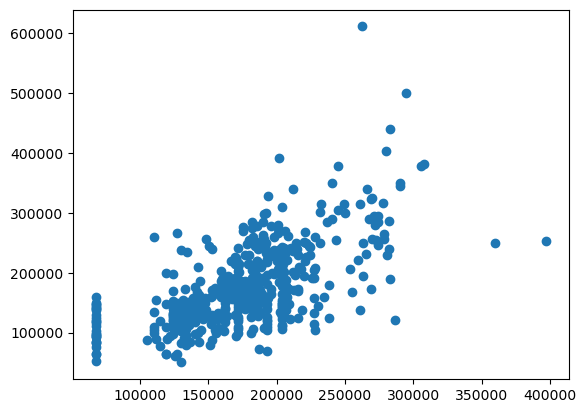

In [5]:
# Split the dataset into a training set and a test set
X = housing_coords[['GarageArea']]  # Feature(s)
y = housing_coords[['SalePrice']]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

# Create a Linear Regression model
lm = LinearRegression()

# Fit the model with the training data
lm.fit(X_train, y_train)

# Print the coefficients and intercept
print("Coefficient:", lm.coef_)
print("Intercept:", lm.intercept_)

# Make predictions on the test set
y_pred = lm.predict(X_test)

# Calculate the R-squared score
lm_r2_score = lm.score(X_test, y_test)
print("R-squared:", lm_r2_score)

plt.scatter(y_pred,y_test)



In [166]:
housing_coords.loc[housing_coords.BsmtBath.isna()]

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,...,SaleCondition,Prop_Addr,MA_Zip1,latitude,longitude,DistanceToISU,BsmtBath,Bath,MiscRmsAbvGrd,Age


In [54]:
# Select only numeric columns
numeric_columns = housing_coords.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()
sorted_corrs = (numeric_columns.corr()['SalePrice']).sort_values(ascending=False).drop(['SalePrice'])
categorical_columns = list(set(housing_coords.columns) - set(numeric_columns.corr()['SalePrice'].index))

OverallQual
R-squared: 0.6051802286986979 

GrLivArea
R-squared: 0.4730303791982675 

TotalBsmtSF
R-squared: 0.44640246996413324 

1stFlrSF
R-squared: 0.41808102243737955 

GarageCars
R-squared: 0.4095256245974921 

GarageArea
R-squared: 0.3976483333076949 

MiscRmsAbvGrd
R-squared: 0.33333486428682957 

Bath
R-squared: 0.37202040186298013 

GarageYrBlt
R-squared: 0.24669539073168711 

YearRemodAdd
R-squared: 0.2095396534409576 



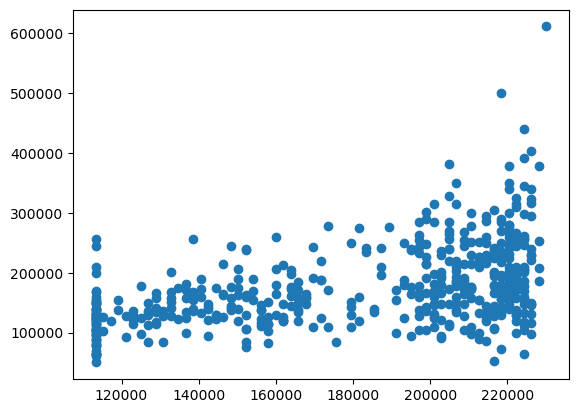

In [7]:
for i in sorted_corrs.index[:10]:
    # Split the dataset into a training set and a test set
    X = housing_coords[[i]]  # Feature(s)
    y = housing_coords[['SalePrice']]  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

    # Create a Linear Regression model
    lm = LinearRegression()

    # Fit the model with the training data
    lm.fit(X_train, y_train)

    # Print the coefficients and intercept
#     print("Coefficient:", lm.coef_)
#     print("Intercept:", lm.intercept_)

    # Make predictions on the test set
    y_pred = lm.predict(X_test)

    # Calculate the R-squared score
    lr_r2_score = lm.score(X_test, y_test)
    print(i)
    print("R-squared:", lr_r2_score,'\n')
plt.scatter(y_pred,y_test)


In [8]:
feature_columns = sorted_corrs.index[:10]

# Extract features and target variable
X = housing_coords[feature_columns]
y = housing_coords['SalePrice']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional, but often recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Linear Regression with 80/20 train/test split')
print(f'Features Used: {list(feature_columns)}','\n')
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2) Score: {r2}')

Linear Regression with 80/20 train/test split
Features Used: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars', 'GarageArea', 'MiscRmsAbvGrd', 'Bath', 'GarageYrBlt', 'YearRemodAdd'] 

Mean Squared Error: 869949196.995385
R-squared (R2) Score: 0.8142713896287384


In [9]:
sorted_corrs.index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars',
       'GarageArea', 'MiscRmsAbvGrd', 'Bath', 'GarageYrBlt', 'YearRemodAdd',
       'TotRmsAbvGrd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF',
       'OpenPorchSF', 'BsmtBath', 'latitude', 'LotArea', '2ndFlrSF',
       'DistanceToISU', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch',
       'LotFrontage', '3SsnPorch', 'PoolArea', 'BsmtFinSF2', 'MoSold',
       'YrSold', 'MA_Zip1', 'MiscVal', 'LowQualFinSF', 'KitchenAbvGr',
       'OverallCond', 'EnclosedPorch', 'longitude', 'Age'],
      dtype='object')

In [10]:
test = list(sorted_corrs.index)
test2 = list(sorted_corrs.index)

test.remove('GrLivArea')
test.remove('TotalBsmtSF')

test2.remove('1stFlrSF')
test2.remove('2ndFlrSF')
test2.remove('LowQualFinSF')
test2.remove('BsmtFinSF1')
test2.remove('BsmtFinSF2')
test2.remove('BsmtUnfSF')

In [11]:
feature_columns = sorted_corrs.index[0:10]
# feature_columns = VIF_columns
# Removing the columns with overlapping features Greatly lowered R2 values...
# feature_columns = test[:10]
feature_columns = test2[:10]

# Extract features and target variable
X = housing_coords[feature_columns]
y = housing_coords['SalePrice']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional, but often recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

# Set up parameter grids for Ridge and Lasso
alpha_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform GridSearchCV for Ridge
ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train_scaled, y_train)

# Perform GridSearchCV for Lasso
lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_scaled, y_train)

# Get the best alpha values
best_alpha_ridge = ridge_grid.best_params_['alpha']
best_alpha_lasso = lasso_grid.best_params_['alpha']

# Ridge Regression
ridge_model_best = Ridge(alpha=best_alpha_ridge)
ridge_model_best.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model_best.predict(X_test_scaled)

# Lasso Regression
lasso_model_best = Lasso(alpha=best_alpha_lasso)  # You can adjust the alpha parameter for regularization strength
lasso_model_best.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model_best.predict(X_test_scaled)

# Evaluate the models
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)


print('80/20 train/test split')
print(f'Features Used: {list(feature_columns)}','\n')

print('Linear Regression:')
print(f'Mean Squared Error: {mse_linear}')
print(f'R-squared (R2) Score: {r2_linear}')

print('\nRidge Regression:')
print(f'Alpha = {best_alpha_ridge} (determined from grid search)')
print(f'Mean Squared Error: {mse_ridge}')
print(f'R-squared (R2) Score: {r2_ridge}')

print('\nLasso Regression:')
print(f'Alpha = {best_alpha_lasso} (determined from grid search)')
print(f'Mean Squared Error: {mse_lasso}')
print(f'R-squared (R2) Score: {r2_lasso}')

print('\nRidge Coefficients:', ridge_model_best.coef_)
print('Ridge Intercept:', ridge_model_best.intercept_)

print('\nLasso Coefficients:', lasso_model_best.coef_)
print('Lasso Intercept:', lasso_model_best.intercept_)


80/20 train/test split
Features Used: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'MiscRmsAbvGrd', 'Bath', 'GarageYrBlt', 'YearRemodAdd', 'TotRmsAbvGrd'] 

Linear Regression:
Mean Squared Error: 819219047.7162697
R-squared (R2) Score: 0.8251019532548425

Ridge Regression:
Alpha = 1 (determined from grid search)
Mean Squared Error: 818845381.2914228
R-squared (R2) Score: 0.8251817286556002

Lasso Regression:
Alpha = 1 (determined from grid search)
Mean Squared Error: 819187122.3467519
R-squared (R2) Score: 0.8251087691178108

Ridge Coefficients: [ 22316.44891493  36956.47971557  17654.80486712   1247.78219204
   6628.34468665  14066.02116529  -5271.35436046   5015.16243844
   6203.01350608 -17411.88021213]
Ridge Intercept: 178817.7711567351

Lasso Coefficients: [ 22310.9930274   37055.95581573  17648.97827231   1235.98043292
   6621.81053611  14101.16447623  -5297.4843194    5025.76383497
   6198.50914942 -17503.52042545]
Lasso Intercept: 178817.7711567351


In [12]:
# Initialize an empty list to store results
results_list = []

for i in range(len(sorted_corrs.index)):
    # Removing the columns with overlapping features Greatly lowered R2 values...
    # feature_columns = test[:10]
    # feature_columns = test2[:10]
    feature_columns = sorted_corrs.index[0:i+1]

    # Extract features and target variable
    X = housing_coords[feature_columns]
    y = housing_coords['SalePrice']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features (optional, but often recommended)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    y_pred_linear = linear_model.predict(X_test_scaled)

    # Set up parameter grids for Ridge and Lasso
    alpha_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform GridSearchCV for Ridge
    ridge_model = Ridge()
    ridge_grid = GridSearchCV(ridge_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    ridge_grid.fit(X_train_scaled, y_train)

    # Perform GridSearchCV for Lasso
    lasso_model = Lasso()
    lasso_grid = GridSearchCV(lasso_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    lasso_grid.fit(X_train_scaled, y_train)

    # Get the best alpha values
    best_alpha_ridge = ridge_grid.best_params_['alpha']
    best_alpha_lasso = lasso_grid.best_params_['alpha']

    # Ridge Regression
    ridge_model_best = Ridge(alpha=best_alpha_ridge)
    ridge_model_best.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge_model_best.predict(X_test_scaled)

    # Lasso Regression
    lasso_model_best = Lasso(alpha=best_alpha_lasso)  # You can adjust the alpha parameter for regularization strength
    lasso_model_best.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso_model_best.predict(X_test_scaled)

    # Evaluate the models
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    r2_linear = r2_score(y_test, y_pred_linear)

    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)


#     print('80/20 train/test split')
#     print(f'Features Used: {list(feature_columns)}','\n')
#     print('TEST2\n\n')
#     print('Linear Regression:')
#     print(f'Mean Squared Error: {mse_linear}')
#     print(f'R-squared (R2) Score: {r2_linear}')

#     print('\nRidge Regression:')
#     print(f'Alpha = {best_alpha_ridge} (determined from grid search)')
#     print(f'Mean Squared Error: {mse_ridge}')
#     print(f'R-squared (R2) Score: {r2_ridge}')

#     print('\nLasso Regression:')
#     print(f'Alpha = {best_alpha_lasso} (determined from grid search)')
#     print(f'Mean Squared Error: {mse_lasso}')
#     print(f'R-squared (R2) Score: {r2_lasso}')

    # print('\nRidge Coefficients:', ridge_model_best.coef_)
    # print('Ridge Intercept:', ridge_model_best.intercept_)

    # print('\nLasso Coefficients:', lasso_model_best.coef_)
    # print('Lasso Intercept:', lasso_model_best.intercept_)
    
    # Append results to the list
    results_list.append({
        'Features Used': list(feature_columns),
        'Linear Regression R2': r2_linear,
        'Ridge Regression R2': r2_ridge, 
        'Lasso Regression R2': r2_lasso
    })

# Create a data frame from the list of results
results_df = pd.DataFrame(results_list)

# Print or use the data frame as needed
# print(results_df)


/Users/nickherman/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.394e+11, tolerance: 9.107e+08
  model = cd_fast.enet_coordinate_descent(
/Users/nickherman/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e+11, tolerance: 9.398e+08
  model = cd_fast.enet_coordinate_descent(
/Users/nickherman/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [13]:
results_df

,Features Used,Linear Regression R2,Ridge Regression R2,Lasso Regression R2
0,[OverallQual],0.60518,0.60518,0.60518
1,"[OverallQual, GrLivArea]",0.70856,0.70860,0.70857
2,"[OverallQual, GrLivArea, TotalBsmtSF]",0.78189,0.78192,0.78191
3,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF]",0.78091,0.78111,0.78092
4,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.79458,0.79478,0.79460
5,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.79890,0.79909,0.79907
6,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.80375,0.80394,0.80377
7,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.80190,0.80240,0.80197
8,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.80452,0.80521,0.80452
9,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.81427,0.81491,0.81427


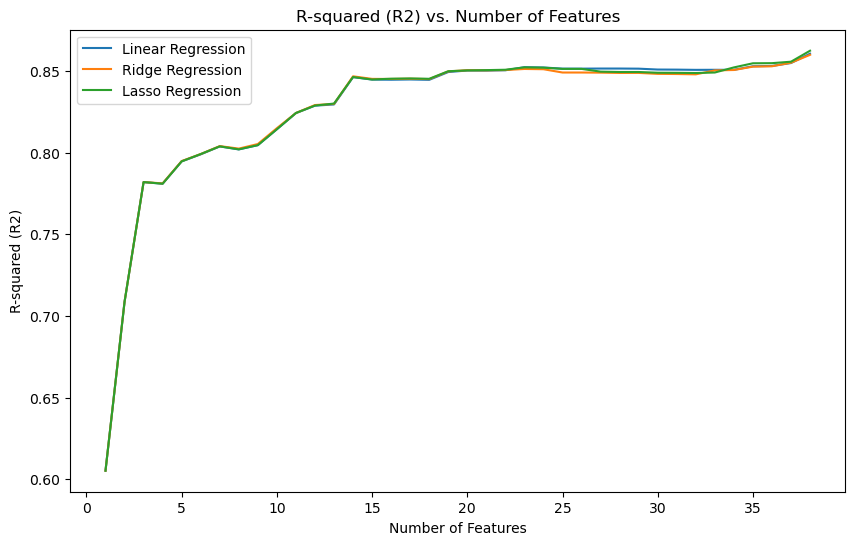

In [14]:
plt.figure(figsize=(10, 6))

# Plotting Linear Regression R2
plt.plot(range(1, len(results_df) + 1), results_df['Linear Regression R2'], label='Linear Regression')

# Plotting Ridge Regression R2
plt.plot(range(1, len(results_df) + 1), results_df['Ridge Regression R2'], label='Ridge Regression')

# Plotting Lasso Regression R2
plt.plot(range(1, len(results_df) + 1), results_df['Lasso Regression R2'], label='Lasso Regression')

plt.title('R-squared (R2) vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R-squared (R2)')
plt.legend()
plt.show()

In [15]:
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
# vif_data

/Users/nickherman/anaconda3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [16]:
# Initialize an empty list to store results
results_list = []

# Specify the number of folds (e.g., k=5 for 5-fold cross-validation)
k_folds = 5

# Create a k-fold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for i in range(len(sorted_corrs.index)):
# for i in range(20):
    feature_columns = sorted_corrs.index[0:i+1]

    X = housing_coords[feature_columns]
    y = housing_coords['SalePrice']

    # Standardize the features (optional, but often recommended)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Linear Regression
    linear_model = LinearRegression()

    # Use cross_val_score for k-fold cross-validation
    r2_scores = cross_val_score(linear_model, X_scaled, y, scoring='r2', cv=kf)

    # Append results to the list
    results_list.append({
        'Features Used': list(feature_columns),
        'Linear Regression R2': r2_scores.mean(),  # Use the average R2 score from cross-validation
        'Fold 1 R2': r2_scores[0],
        'Fold 2 R2': r2_scores[1], 
        'Fold 3 R2': r2_scores[2], 
        'Fold 4 R2': r2_scores[3], 
        'Fold 5 R2': r2_scores[4], 
        'Standard Deviation':r2_scores.std()
    })

# Create a data frame from the list of results
KF_results_df = pd.DataFrame(results_list)


In [ ]:
r2_scores

In [17]:
KF_results_df

,Features Used,Linear Regression R2,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Standard Deviation
0,[OverallQual],0.62823,0.60518,0.62770,0.66175,0.61486,0.63167,0.01921
1,"[OverallQual, GrLivArea]",0.74339,0.70856,0.74304,0.76797,0.73839,0.75898,0.02042
2,"[OverallQual, GrLivArea, TotalBsmtSF]",0.80008,0.78189,0.79559,0.81254,0.79926,0.81113,0.01122
3,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF]",0.80192,0.78091,0.79965,0.81061,0.80253,0.81591,0.01199
4,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.81195,0.79458,0.80778,0.81745,0.81205,0.82791,0.01099
5,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.81462,0.79890,0.80505,0.82114,0.81670,0.83132,0.01153
6,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.81705,0.80375,0.80607,0.82698,0.81986,0.82861,0.01037
7,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.81666,0.80190,0.80609,0.82698,0.81968,0.82863,0.01085
8,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.82197,0.80452,0.81075,0.83390,0.82715,0.83351,0.01210
9,"[OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF...",0.82745,0.81427,0.81581,0.83177,0.83181,0.84360,0.01102


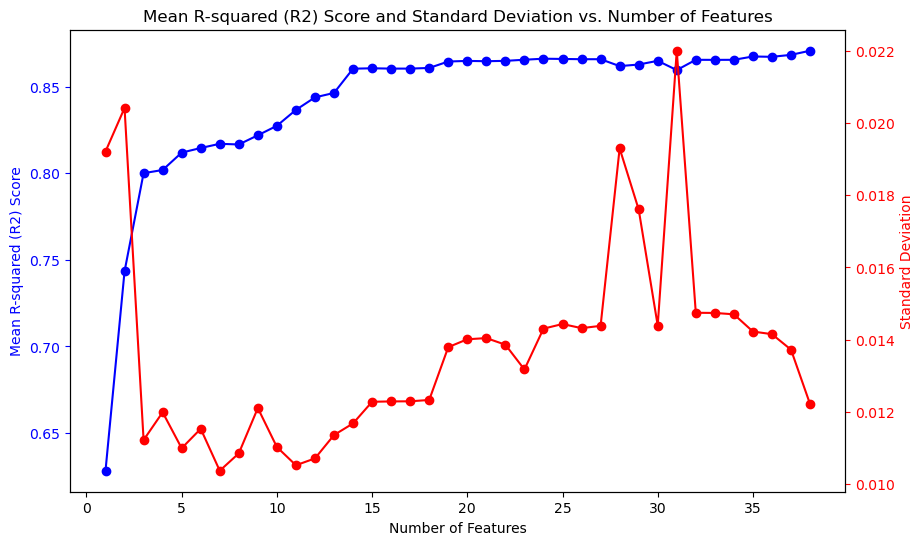

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting mean R2 score on the left y-axis
ax1.plot(range(1, len(KF_results_df) + 1), KF_results_df['Linear Regression R2'], marker='o', label='Mean R2 Score', color='blue')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Mean R-squared (R2) Score', color='blue')
ax1.tick_params('y', colors='blue')

# Create a secondary y-axis on the right side for standard deviation
ax2 = ax1.twinx()
ax2.plot(range(1, len(KF_results_df) + 1), KF_results_df['Standard Deviation'], marker='o', label='Standard Deviation', color='red')
ax2.set_ylabel('Standard Deviation', color='red')
ax2.tick_params('y', colors='red')

plt.title('Mean R-squared (R2) Score and Standard Deviation vs. Number of Features')
plt.show()


In [31]:
Ames_HousePrice.loc[Ames_HousePrice.MiscFeature.notna()].MiscFeature.value_counts()

MiscFeature
Shed    88
Gar2     5
Othr     3
TenC     1
Name: count, dtype: int64

In [57]:
# Assuming your target variable is in the 'target_column' column
target_column = 'SalePrice'

# Separate features and target variable
X = housing_coords.drop(target_column, axis=1)
y = housing_coords[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # You can customize the imputer strategy
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # You can customize the imputer strategy
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ])

# Create a pipeline with preprocessor and the MLR model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

# # Use 5-fold cross-validation
# cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
# cv_scores_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')


# # Convert the negative mean squared error to positive
# cv_scores = -cv_scores

# # Display cross-validation results
# print(f'Cross-Validation Mean Squared Error: {cv_scores.mean()}')
# print(f'Cross-Validation R-squared: {cv_scores_r2.mean()}')

# for i, (mse, r2) in enumerate(zip(cv_scores, cv_scores_r2), 1):
#     print(f'Fold {i}: Mean Squared Error = {mse}, R-squared = {r2}')

Mean Squared Error: 428952635.38812417
R-squared: 0.9224454253475323


In [42]:
# Assuming your target variable is in the 'target_column' column
target_column = 'SalePrice'

# Separate features and target variable
X = housing_coords.drop(target_column, axis=1)
y = housing_coords[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore')),])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features),])

# Create a pipeline with preprocessor and the MLR model
model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

r2_scorelist = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create a Linear Regression model
    # model = LinearRegression()
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate R-squared for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scorelist.append(r2)

    print(f"Fold R^2: {r2:.4f}")
    
average_r2 = np.mean(r2_scorelist)
print(f"Average R^2: {average_r2:.4f}")


Fold R^2: 0.9038
Fold R^2: 0.9190
Fold R^2: 0.9162
Fold R^2: 0.9160
Fold R^2: 0.9276
Average R^2: 0.9165


In [63]:
# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = housing_coords.drop(target_column, axis=1)
y = housing_coords[target_column]

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore')),])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features),])

# Models to loop through
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

# Initialize an empty list to store results
results_list = []

# Loop over each model
for model_name, model in models.items():
    # print(f"\nTraining {model_name} model")
    
    # Create a pipeline with preprocessor and the current model
    full_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    r2_scorelist = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        full_model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = full_model.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)

        # Append results to the list
        results_list.append({'Model': model_name, 'Fold': fold, 'R2': r2})
        
        # print(f"{model_name} - Fold {fold} - R^2: {r2:.4f}")

    # Calculate and print the average R-squared across folds for the current model
    average_r2 = np.mean(r2_scorelist)
    # print(f"{model_name} - Average R^2: {average_r2:.4f}")

# Create the overall results DataFrame
results_df_temp = pd.DataFrame(results_list)


Training Linear Regression model
Linear Regression - Fold 1 - R^2: 0.9038
Linear Regression - Fold 2 - R^2: 0.9190
Linear Regression - Fold 3 - R^2: 0.9162
Linear Regression - Fold 4 - R^2: 0.9160
Linear Regression - Fold 5 - R^2: 0.9276
Linear Regression - Average R^2: 0.9165

Training Lasso model
Lasso - Fold 1 - R^2: 0.9032
Lasso - Fold 2 - R^2: 0.9226
Lasso - Fold 3 - R^2: 0.9227
Lasso - Fold 4 - R^2: 0.9267
Lasso - Fold 5 - R^2: 0.9327
Lasso - Average R^2: 0.9216

Training Ridge model
Ridge - Fold 1 - R^2: 0.9130
Ridge - Fold 2 - R^2: 0.9234
Ridge - Fold 3 - R^2: 0.9262
Ridge - Fold 4 - R^2: 0.9267
Ridge - Fold 5 - R^2: 0.9361
Ridge - Average R^2: 0.9251

Training ElasticNet model
ElasticNet - Fold 1 - R^2: 0.8718
ElasticNet - Fold 2 - R^2: 0.8682
ElasticNet - Fold 3 - R^2: 0.8904
ElasticNet - Fold 4 - R^2: 0.8948
ElasticNet - Fold 5 - R^2: 0.9134
ElasticNet - Average R^2: 0.8877

Overall Results:
                Model  Fold   R2
0   Linear Regression     1 0.90
1   Linear Regres

In [96]:
pivoted_df = results_df_temp.pivot(index='Model', columns='Fold', values='R2').reset_index().set_index('Model')
pivoted_df.columns = [f'Fold_{col}' if col != 'Model' else col for col in pivoted_df.columns]
pivoted_df['mean_R2'] = pivoted_df.mean(axis=1)
pivoted_df['std'] = pivoted_df.std(axis=1)
pivoted_df.sort_values(by='mean_R2',ascending=False)

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,mean_R2,std
Model,,,,,,,
Ridge,0.913032,0.923399,0.926178,0.926668,0.936059,0.925067,0.007379
Lasso,0.903185,0.922622,0.922717,0.926668,0.932708,0.921580,0.009904
Linear Regression,0.903786,0.918992,0.916247,0.915996,0.927646,0.916533,0.007647
ElasticNet,0.871826,0.868163,0.890415,0.894833,0.913406,0.887729,0.016448


In [26]:
housing_num = housing_coords.select_dtypes(exclude=[object])
features = list(housing_num.columns.values)
features.remove('SalePrice')
X = housing_coords[features]  # Features
y = housing_coords['SalePrice']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

  2%|█                                           | 1/42 [00:00<00:10,  3.88it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8052803556009197, 'Adjusted R-Squared': 0.789229712461733, 'RMSE': 30200.381213329965, 'Time taken': 0.2572312355041504}


 14%|██████▎                                     | 6/42 [00:00<00:02, 13.76it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8749524104774742, 'Adjusted R-Squared': 0.8646448000613007, 'RMSE': 24201.662672141763, 'Time taken': 0.2100679874420166}
{'Model': 'BayesianRidge', 'R-Squared': 0.8593062836631284, 'Adjusted R-Squared': 0.8477089708197421, 'RMSE': 25671.124432828645, 'Time taken': 0.042385101318359375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7620351390730085, 'Adjusted R-Squared': 0.7424198143111307, 'RMSE': 33385.96678492327, 'Time taken': 0.04288601875305176}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011593988735663086, 'Adjusted R-Squared': -0.08368446862887113, 'RMSE': 68479.27528349646, 'Time taken': 0.006788015365600586}
{'Model': 'ElasticNet', 'R-Squared': 0.7849188004684498, 'Adjusted R-Squared': 0.767189764498387, 'RMSE': 31740.13474242726, 'Time taken': 0.009631156921386719}
{'Model': 'ElasticNetCV', 'R-Squared': 0.17804812903100742, 'Adjusted R-Squared': 0.1102950463914808, 'RMSE': 62048.42117041793, 'Time taken': 0.07125306129455566

 21%|█████████▍                                  | 9/42 [00:01<00:06,  5.01it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8904178530153807, 'Adjusted R-Squared': 0.8813850513116593, 'RMSE': 22655.69783038078, 'Time taken': 0.9679830074310303}
{'Model': 'GammaRegressor', 'R-Squared': -2.72509326827243, 'Adjusted R-Squared': -3.0321508478697234, 'RMSE': 132091.87857015603, 'Time taken': 0.04563474655151367}


 26%|███████████▎                               | 11/42 [00:01<00:05,  5.21it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.221453418737638, 'Adjusted R-Squared': -5.7342847200652525, 'RMSE': 170707.84034065477, 'Time taken': 0.30130791664123535}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8952481057756075, 'Adjusted R-Squared': 0.8866134593970242, 'RMSE': 22150.752453170993, 'Time taken': 0.7371320724487305}


 38%|████████████████▍                          | 16/42 [00:03<00:06,  4.29it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9092403065428093, 'Adjusted R-Squared': 0.9017590302925419, 'RMSE': 20618.356823813065, 'Time taken': 0.7182128429412842}
{'Model': 'HuberRegressor', 'R-Squared': 0.5396810136197279, 'Adjusted R-Squared': 0.5017371492326338, 'RMSE': 46434.09496403739, 'Time taken': 0.030073881149291992}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.835497312158889, 'Adjusted R-Squared': 0.8219374376730707, 'RMSE': 27758.37511251118, 'Time taken': 0.0158841609954834}
{'Model': 'KernelRidge', 'R-Squared': -5.908644454284844, 'Adjusted R-Squared': -6.4781205698224245, 'RMSE': 179888.73281178036, 'Time taken': 0.09425783157348633}
{'Model': 'Lars', 'R-Squared': 0.8604694270500202, 'Adjusted R-Squared': 0.8489679915357051, 'RMSE': 25564.790017805597, 'Time taken': 0.012285232543945312}
{'Model': 'LarsCV', 'R-Squared': 0.8562220684974635, 'Adjusted R-Squared': 0.8443705253367338, 'RMSE': 25950.973651634355, 'Time taken': 0.02953505516052246}


 55%|███████████████████████▌                   | 23/42 [00:03<00:02,  9.18it/s]

{'Model': 'Lasso', 'R-Squared': 0.8604700840573231, 'Adjusted R-Squared': 0.8489687026997922, 'RMSE': 25564.729829299395, 'Time taken': 0.0863640308380127}
{'Model': 'LassoCV', 'R-Squared': 0.8641909873138574, 'Adjusted R-Squared': 0.8529963181553466, 'RMSE': 25221.553734739027, 'Time taken': 0.0514678955078125}
{'Model': 'LassoLars', 'R-Squared': 0.860492394337696, 'Adjusted R-Squared': 0.8489928520054453, 'RMSE': 25562.685898119675, 'Time taken': 0.009335756301879883}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8641390090414405, 'Adjusted R-Squared': 0.8529400553398672, 'RMSE': 25226.37980390595, 'Time taken': 0.028588056564331055}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8646751170547822, 'Adjusted R-Squared': 0.8535203544692761, 'RMSE': 25176.5589091963, 'Time taken': 0.018080949783325195}
{'Model': 'LinearRegression', 'R-Squared': 0.8604093365226421, 'Adjusted R-Squared': 0.8489029477761353, 'RMSE': 25570.294318123633, 'Time taken': 0.015217065811157227}
{'Model': 'LinearSVR', 'R-Squar

 67%|████████████████████████████▋              | 28/42 [00:05<00:02,  6.23it/s]

{'Model': 'MLPRegressor', 'R-Squared': -6.240019178600884, 'Adjusted R-Squared': -6.836810347335881, 'RMSE': 184152.40686262806, 'Time taken': 0.9895749092102051}
{'Model': 'NuSVR', 'R-Squared': -0.010115071811370946, 'Adjusted R-Squared': -0.09337835321881593, 'RMSE': 68784.87727059198, 'Time taken': 0.18944978713989258}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7603513848941093, 'Adjusted R-Squared': 0.7405972691153156, 'RMSE': 33503.87216389746, 'Time taken': 0.00892019271850586}


 79%|█████████████████████████████████▊         | 33/42 [00:05<00:00,  9.65it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8085635069349029, 'Adjusted R-Squared': 0.7927834923221617, 'RMSE': 29944.695831932975, 'Time taken': 0.014944076538085938}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.3181305050791112, 'Adjusted R-Squared': 0.26192434280797494, 'RMSE': 56514.27648048477, 'Time taken': 0.06439590454101562}
{'Model': 'PoissonRegressor', 'R-Squared': -0.9186436092332844, 'Adjusted R-Squared': -1.0767964447015381, 'RMSE': 94799.2053336583, 'Time taken': 0.0209348201751709}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': 0.42542391597239526, 'Adjusted R-Squared': 0.37806189603085727, 'RMSE': 51877.77170665488, 'Time taken': 0.09896492958068848}


 83%|███████████████████████████████████▊       | 35/42 [00:07<00:02,  3.10it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8844783710151564, 'Adjusted R-Squared': 0.8749559807734556, 'RMSE': 23261.579101550484, 'Time taken': 1.9360499382019043}
{'Model': 'Ridge', 'R-Squared': 0.8604081741373707, 'Adjusted R-Squared': 0.848901689576026, 'RMSE': 25570.40078108786, 'Time taken': 0.008184194564819336}
{'Model': 'RidgeCV', 'R-Squared': 0.8598219275065135, 'Adjusted R-Squared': 0.8482671189278748, 'RMSE': 25624.03879010813, 'Time taken': 0.01689291000366211}
{'Model': 'SGDRegressor', 'R-Squared': 0.8296592555028424, 'Adjusted R-Squared': 0.8156181529195625, 'RMSE': 28246.641086410567, 'Time taken': 0.010668039321899414}


 90%|██████████████████████████████████████▉    | 38/42 [00:07<00:00,  4.02it/s]

{'Model': 'SVR', 'R-Squared': -0.062361933044770224, 'Adjusted R-Squared': -0.14993189715692057, 'RMSE': 70541.3539883291, 'Time taken': 0.30567479133605957}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8604093365226421, 'Adjusted R-Squared': 0.8489029477761353, 'RMSE': 25570.294318123633, 'Time taken': 0.015408039093017578}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7517079680182288, 'Adjusted R-Squared': 0.7312413796986902, 'RMSE': 34102.713182886946, 'Time taken': 0.0155029296875}


 98%|█████████████████████████████████████████▉ | 41/42 [00:07<00:00,  4.85it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8910177371713591, 'Adjusted R-Squared': 0.8820343836193236, 'RMSE': 22593.600830051637, 'Time taken': 0.33411192893981934}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4237
[LightGBM] [Info] Number of data points in the train set: 1997, number of used features: 37
[LightGBM] [Info] Start training from score 178817.771157


100%|███████████████████████████████████████████| 42/42 [00:08<00:00,  4.90it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9067960315056784, 'Adjusted R-Squared': 0.8991132748835868, 'RMSE': 20894.15168955877, 'Time taken': 0.6862080097198486}
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor                0.90       0.91  20618.36   
LGBMRegressor                                0.90       0.91  20894.15   
GradientBoostingRegressor                    0.89       0.90  22150.75   
XGBRegressor                                 0.88       0.89  22593.60   
ExtraTreesRegressor                          0.88       0.89  22655.70   
RandomForestRegressor                        0.87       0.88  23261.58   
BaggingRegressor                             0.86       0.87  24201.66   
LassoLarsIC                                  0.85       0.86  25176.56   
LassoCV                                      0.85       0.86  25221.55   
LassoLarsCV            

In [139]:
features = list(housing_coords.select_dtypes(exclude=[object]))
features.remove('SalePrice')
X = housing_coords[features]
y = housing_coords['SalePrice']

reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_dict = {}

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    
    # Save the models in a dictionary
    model_dict[f'model_{i+1}'] = models

  5%|██                                          | 2/42 [00:00<00:08,  4.59it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7994676724958087, 'Adjusted R-Squared': 0.7829378927883048, 'RMSE': 30647.830591890473, 'Time taken': 0.25650691986083984}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8704254205724764, 'Adjusted R-Squared': 0.8597446526370189, 'RMSE': 24635.84398235871, 'Time taken': 0.19007492065429688}


 17%|███████▎                                    | 7/42 [00:00<00:02, 16.94it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.8593062836631316, 'Adjusted R-Squared': 0.8477089708197454, 'RMSE': 25671.12443282837, 'Time taken': 0.015954017639160156}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7620351390730085, 'Adjusted R-Squared': 0.7424198143111307, 'RMSE': 33385.96678492327, 'Time taken': 0.035459041595458984}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011593988735663086, 'Adjusted R-Squared': -0.08368446862887113, 'RMSE': 68479.27528349646, 'Time taken': 0.005146980285644531}
{'Model': 'ElasticNet', 'R-Squared': 0.7849188004684501, 'Adjusted R-Squared': 0.7671897644983874, 'RMSE': 31740.134742427235, 'Time taken': 0.007748126983642578}
{'Model': 'ElasticNetCV', 'R-Squared': 0.1780481290310073, 'Adjusted R-Squared': 0.11029504639148069, 'RMSE': 62048.42117041794, 'Time taken': 0.04125213623046875}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7082448836372934, 'Adjusted R-Squared': 0.6841956549566365, 'RMSE': 36967.21909952113, 'Time taken': 0.0184488296508

 24%|██████████▏                                | 10/42 [00:01<00:05,  6.13it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8904178530153807, 'Adjusted R-Squared': 0.8813850513116593, 'RMSE': 22655.69783038078, 'Time taken': 0.9099981784820557}
{'Model': 'GammaRegressor', 'R-Squared': -2.72509326827243, 'Adjusted R-Squared': -3.0321508478697234, 'RMSE': 132091.87857015603, 'Time taken': 0.010521173477172852}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.221453418737634, 'Adjusted R-Squared': -5.734284720065249, 'RMSE': 170707.84034065471, 'Time taken': 0.27967119216918945}


 29%|████████████▎                              | 12/42 [00:02<00:07,  3.95it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8955444366071299, 'Adjusted R-Squared': 0.8869342166311449, 'RMSE': 22119.399322606772, 'Time taken': 0.6896226406097412}


 38%|████████████████▍                          | 16/42 [00:03<00:05,  5.08it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9092403065428093, 'Adjusted R-Squared': 0.9017590302925419, 'RMSE': 20618.356823813065, 'Time taken': 0.48304009437561035}
{'Model': 'HuberRegressor', 'R-Squared': 0.539681013621098, 'Adjusted R-Squared': 0.5017371492341169, 'RMSE': 46434.09496396828, 'Time taken': 0.03038167953491211}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.835497312158889, 'Adjusted R-Squared': 0.8219374376730707, 'RMSE': 27758.37511251118, 'Time taken': 0.015196800231933594}
{'Model': 'KernelRidge', 'R-Squared': -5.908644454285122, 'Adjusted R-Squared': -6.478120569822725, 'RMSE': 179888.73281178396, 'Time taken': 0.09666800498962402}
{'Model': 'Lars', 'R-Squared': 0.8604694270500197, 'Adjusted R-Squared': 0.8489679915357047, 'RMSE': 25564.790017805637, 'Time taken': 0.009563922882080078}
{'Model': 'LarsCV', 'R-Squared': 0.8646989616456069, 'Adjusted R-Squared': 0.8535461645578261, 'RMSE': 25174.34072441196, 'Time taken': 0.025063037872314453}


 57%|████████████████████████▌                  | 24/42 [00:03<00:01, 12.23it/s]

{'Model': 'Lasso', 'R-Squared': 0.8604700840573231, 'Adjusted R-Squared': 0.8489687026997922, 'RMSE': 25564.729829299402, 'Time taken': 0.0882570743560791}
{'Model': 'LassoCV', 'R-Squared': 0.8647094145988505, 'Adjusted R-Squared': 0.8535574791427905, 'RMSE': 25173.368258522554, 'Time taken': 0.046488046646118164}
{'Model': 'LassoLars', 'R-Squared': 0.8604923943376963, 'Adjusted R-Squared': 0.8489928520054457, 'RMSE': 25562.685898119642, 'Time taken': 0.007876157760620117}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8646989616456069, 'Adjusted R-Squared': 0.8535461645578261, 'RMSE': 25174.34072441196, 'Time taken': 0.022449970245361328}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8646751170547817, 'Adjusted R-Squared': 0.8535203544692757, 'RMSE': 25176.558909196337, 'Time taken': 0.01640915870666504}
{'Model': 'LinearRegression', 'R-Squared': 0.8513583902654562, 'Adjusted R-Squared': 0.8391059365346262, 'RMSE': 26386.254142395683, 'Time taken': 0.011219024658203125}
{'Model': 'LinearSVR', 'R-S

 64%|███████████████████████████▋               | 27/42 [00:04<00:02,  6.27it/s]

{'Model': 'MLPRegressor', 'R-Squared': -6.240816638256145, 'Adjusted R-Squared': -6.837673541192661, 'RMSE': 184162.5484152705, 'Time taken': 0.8580689430236816}
{'Model': 'NuSVR', 'R-Squared': -0.010115071811370946, 'Adjusted R-Squared': -0.09337835321881593, 'RMSE': 68784.87727059198, 'Time taken': 0.18384575843811035}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.760351384894109, 'Adjusted R-Squared': 0.7405972691153153, 'RMSE': 33503.872163897475, 'Time taken': 0.006684064865112305}


 76%|████████████████████████████████▊          | 32/42 [00:04<00:01,  9.73it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8085635069349028, 'Adjusted R-Squared': 0.7927834923221615, 'RMSE': 29944.695831932982, 'Time taken': 0.012547016143798828}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.31080876345845054, 'Adjusted R-Squared': 0.25399907367845287, 'RMSE': 56816.88429854626, 'Time taken': 0.06362700462341309}
{'Model': 'PoissonRegressor', 'R-Squared': -0.9186436099855813, 'Adjusted R-Squared': -1.0767964455158463, 'RMSE': 94799.2053522436, 'Time taken': 0.01512002944946289}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': -3.23351185490679e+21, 'Adjusted R-Squared': -3.5000486238578923e+21, 'RMSE': 3891748528538462.5, 'Time taken': 0.09686970710754395}


 83%|███████████████████████████████████▊       | 35/42 [00:06<00:01,  4.09it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8852965822575252, 'Adjusted R-Squared': 0.8758416367603147, 'RMSE': 23179.05469943771, 'Time taken': 1.841257095336914}
{'Model': 'Ridge', 'R-Squared': 0.8604081741373715, 'Adjusted R-Squared': 0.8489016895760269, 'RMSE': 25570.40078108779, 'Time taken': 0.008296966552734375}
{'Model': 'RidgeCV', 'R-Squared': 0.859821927506477, 'Adjusted R-Squared': 0.8482671189278352, 'RMSE': 25624.03879011146, 'Time taken': 0.01815199851989746}
{'Model': 'SGDRegressor', 'R-Squared': 0.8444441590337946, 'Adjusted R-Squared': 0.831621768672155, 'RMSE': 26992.9719041132, 'Time taken': 0.008022785186767578}


 90%|██████████████████████████████████████▉    | 38/42 [00:06<00:00,  4.82it/s]

{'Model': 'SVR', 'R-Squared': -0.062361933044770224, 'Adjusted R-Squared': -0.14993189715692057, 'RMSE': 70541.3539883291, 'Time taken': 0.29565906524658203}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8513583902654562, 'Adjusted R-Squared': 0.8391059365346262, 'RMSE': 26386.254142395683, 'Time taken': 0.012755870819091797}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7517079680098993, 'Adjusted R-Squared': 0.731241379689674, 'RMSE': 34102.71318345897, 'Time taken': 0.012140035629272461}


 98%|█████████████████████████████████████████▉ | 41/42 [00:07<00:00,  5.61it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8910177371713591, 'Adjusted R-Squared': 0.8820343836193236, 'RMSE': 22593.600830051637, 'Time taken': 0.28450465202331543}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4237
[LightGBM] [Info] Number of data points in the train set: 1997, number of used features: 37
[LightGBM] [Info] Start training from score 178817.771157


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.72it/s]


{'Model': 'LGBMRegressor', 'R-Squared': 0.9067960315056784, 'Adjusted R-Squared': 0.8991132748835868, 'RMSE': 20894.15168955877, 'Time taken': 0.290477991104126}
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  5%|██                                          | 2/42 [00:00<00:08,  4.79it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8457441565882792, 'Adjusted R-Squared': 0.833028924376467, 'RMSE': 30970.555828886427, 'Time taken': 0.24102520942687988}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8733416489171791, 'Adjusted R-Squared': 0.8629012642292242, 'RMSE': 28063.711190409584, 'Time taken': 0.18559503555297852}
{'Model': 'BayesianRidge', 'R-Squared': 0.8552859827454197, 'Adjusted R-Squared': 0.8433572785031767, 'RMSE': 29997.391227586766, 'Time taken': 0.013746023178100586}


 17%|███████▎                                    | 7/42 [00:00<00:01, 17.61it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7528648146077457, 'Adjusted R-Squared': 0.7324935845754124, 'RMSE': 39200.849475311115, 'Time taken': 0.035485029220581055}
{'Model': 'DummyRegressor', 'R-Squared': -0.002218814892503973, 'Adjusted R-Squared': -0.08483121178169095, 'RMSE': 78942.24322965916, 'Time taken': 0.0052242279052734375}
{'Model': 'ElasticNet', 'R-Squared': 0.8341504412947542, 'Adjusted R-Squared': 0.82047954491558, 'RMSE': 32113.330395383993, 'Time taken': 0.007275819778442383}
{'Model': 'ElasticNetCV', 'R-Squared': 0.16304751563711783, 'Adjusted R-Squared': 0.09405793991957001, 'RMSE': 72140.40710366426, 'Time taken': 0.04080629348754883}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7869425786957719, 'Adjusted R-Squared': 0.7693803617552932, 'RMSE': 36397.91618134203, 'Time taken': 0.01760101318359375}


 24%|██████████▏                                | 10/42 [00:01<00:05,  5.93it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9050666215713369, 'Adjusted R-Squared': 0.8972413105511867, 'RMSE': 24296.16093620211, 'Time taken': 0.9603941440582275}
{'Model': 'GammaRegressor', 'R-Squared': 0.8726572746418026, 'Adjusted R-Squared': 0.8621604773237733, 'RMSE': 28139.427507577155, 'Time taken': 0.011311769485473633}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.111571060215291, 'Adjusted R-Squared': -4.532915312467312, 'RMSE': 178281.1343531313, 'Time taken': 0.24654579162597656}


 29%|████████████▎                              | 12/42 [00:02<00:07,  3.97it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9154596552481793, 'Adjusted R-Squared': 0.9084910368087667, 'RMSE': 22927.68438039806, 'Time taken': 0.6858208179473877}


 40%|█████████████████▍                         | 17/42 [00:03<00:04,  5.88it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8981341650992072, 'Adjusted R-Squared': 0.8897374151507688, 'RMSE': 25167.63819031748, 'Time taken': 0.48851799964904785}
{'Model': 'HuberRegressor', 'R-Squared': 0.8372796480396345, 'Adjusted R-Squared': 0.8238666906112313, 'RMSE': 31808.934721113, 'Time taken': 0.0229489803314209}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8246270034078034, 'Adjusted R-Squared': 0.8101710947949976, 'RMSE': 33022.46958086206, 'Time taken': 0.01168680191040039}
{'Model': 'KernelRidge', 'R-Squared': -4.205457755411456, 'Adjusted R-Squared': -4.634541041106978, 'RMSE': 179910.97226506466, 'Time taken': 0.08123278617858887}
{'Model': 'Lars', 'R-Squared': 0.8542176114442329, 'Adjusted R-Squared': 0.84220084188866, 'RMSE': 30107.917559088277, 'Time taken': 0.009545087814331055}
{'Model': 'LarsCV', 'R-Squared': 0.8560909383170213, 'Adjusted R-Squared': 0.8442285861609407, 'RMSE': 29913.846317699932, 'Time taken': 0.025928974151611328}


 57%|████████████████████████▌                  | 24/42 [00:03<00:01, 12.24it/s]

{'Model': 'Lasso', 'R-Squared': 0.8554804068899248, 'Adjusted R-Squared': 0.843567728932912, 'RMSE': 29977.233617912487, 'Time taken': 0.07649517059326172}
{'Model': 'LassoCV', 'R-Squared': 0.8562436329255898, 'Adjusted R-Squared': 0.8443938673099117, 'RMSE': 29897.972072957185, 'Time taken': 0.04796314239501953}
{'Model': 'LassoLars', 'R-Squared': 0.8554748446284148, 'Adjusted R-Squared': 0.843561708176961, 'RMSE': 29977.81049335473, 'Time taken': 0.008335113525390625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8562413121518346, 'Adjusted R-Squared': 0.8443913552359338, 'RMSE': 29898.213405394465, 'Time taken': 0.02456188201904297}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8562370009737328, 'Adjusted R-Squared': 0.8443866886895719, 'RMSE': 29898.66171067081, 'Time taken': 0.015497922897338867}
{'Model': 'LinearRegression', 'R-Squared': 0.8554688009152305, 'Adjusted R-Squared': 0.8435551662835141, 'RMSE': 29978.437288717745, 'Time taken': 0.012166023254394531}
{'Model': 'LinearSVR', 'R-Squa

 64%|███████████████████████████▋               | 27/42 [00:04<00:02,  6.36it/s]

{'Model': 'MLPRegressor', 'R-Squared': -4.943064970924351, 'Adjusted R-Squared': -5.432948851391001, 'RMSE': 192235.42688646846, 'Time taken': 0.8217790126800537}
{'Model': 'NuSVR', 'R-Squared': -0.021449712354327577, 'Adjusted R-Squared': -0.10564730252670174, 'RMSE': 79696.02903635043, 'Time taken': 0.1843550205230713}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8126724998898105, 'Adjusted R-Squared': 0.7972311875163025, 'RMSE': 34129.42379170525, 'Time taken': 0.006821155548095703}


 74%|███████████████████████████████▋           | 31/42 [00:04<00:01,  9.07it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8315315281721478, 'Adjusted R-Squared': 0.8176447560908932, 'RMSE': 32365.88640836856, 'Time taken': 0.013441085815429688}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.832039543133377, 'Adjusted R-Squared': 0.8181946464719201, 'RMSE': 32317.050063760616, 'Time taken': 0.06747984886169434}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9078943852900365, 'Adjusted R-Squared': 0.9003021654224039, 'RMSE': 23931.572710523287, 'Time taken': 0.018790006637573242}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': 0.7040469256280567, 'Adjusted R-Squared': 0.6796516613631243, 'RMSE': 42898.25389554795, 'Time taken': 0.08708405494689941}


 81%|██████████████████████████████████▊        | 34/42 [00:06<00:02,  3.92it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8916592496498548, 'Adjusted R-Squared': 0.8827287756513612, 'RMSE': 25955.183697698343, 'Time taken': 1.7988831996917725}
{'Model': 'Ridge', 'R-Squared': 0.8554551608420287, 'Adjusted R-Squared': 0.8435404018658835, 'RMSE': 29979.851856764315, 'Time taken': 0.006577014923095703}
{'Model': 'RidgeCV', 'R-Squared': 0.855366289958318, 'Adjusted R-Squared': 0.8434442053995677, 'RMSE': 29989.06673617207, 'Time taken': 0.01343536376953125}
{'Model': 'SGDRegressor', 'R-Squared': 0.856076094844267, 'Adjusted R-Squared': 0.8442125191481329, 'RMSE': 29915.38900691096, 'Time taken': 0.0069239139556884766}


 90%|██████████████████████████████████████▉    | 38/42 [00:06<00:00,  5.13it/s]

{'Model': 'SVR', 'R-Squared': -0.07126083439906794, 'Adjusted R-Squared': -0.15956433051005403, 'RMSE': 81616.0929934135, 'Time taken': 0.3015778064727783}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8554688009152305, 'Adjusted R-Squared': 0.8435551662835141, 'RMSE': 29978.437288717745, 'Time taken': 0.012137889862060547}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8136830509667172, 'Adjusted R-Squared': 0.7983250378142991, 'RMSE': 34037.24254265621, 'Time taken': 0.010024070739746094}


 98%|█████████████████████████████████████████▉ | 41/42 [00:06<00:00,  5.86it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8972606896434427, 'Adjusted R-Squared': 0.888791939548976, 'RMSE': 25275.311139730344, 'Time taken': 0.2913980484008789}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4234
[LightGBM] [Info] Number of data points in the train set: 1997, number of used features: 37
[LightGBM] [Info] Start training from score 177607.365548


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.82it/s]


{'Model': 'LGBMRegressor', 'R-Squared': 0.8984177187941947, 'Adjusted R-Squared': 0.8900443420353648, 'RMSE': 25132.58546661574, 'Time taken': 0.2873978614807129}
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  5%|██                                          | 2/42 [00:00<00:08,  4.68it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8225667569896494, 'Adjusted R-Squared': 0.8079092282192292, 'RMSE': 32669.561647223203, 'Time taken': 0.250730037689209}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8800711098837766, 'Adjusted R-Squared': 0.8701639407002625, 'RMSE': 26858.86889526075, 'Time taken': 0.1876230239868164}


 17%|███████▎                                    | 7/42 [00:00<00:02, 17.19it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.8740668284718082, 'Adjusted R-Squared': 0.8636636534325228, 'RMSE': 27523.007120877224, 'Time taken': 0.014148950576782227}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7503857577318132, 'Adjusted R-Squared': 0.7297654507618325, 'RMSE': 38748.99943056259, 'Time taken': 0.03610587120056152}
{'Model': 'DummyRegressor', 'R-Squared': -0.00031085276618503244, 'Adjusted R-Squared': -0.0829452275599134, 'RMSE': 77569.9126500137, 'Time taken': 0.005067110061645508}
{'Model': 'ElasticNet', 'R-Squared': 0.857639646541541, 'Adjusted R-Squared': 0.8458794434297553, 'RMSE': 29263.10063735466, 'Time taken': 0.010174989700317383}
{'Model': 'ElasticNetCV', 'R-Squared': 0.16958924202096226, 'Adjusted R-Squared': 0.10099009244878088, 'RMSE': 70676.05425790342, 'Time taken': 0.03945660591125488}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7467900271198753, 'Adjusted R-Squared': 0.7258726815341259, 'RMSE': 39027.09408802956, 'Time taken': 0.017611980438232

 24%|██████████▏                                | 10/42 [00:01<00:05,  6.18it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9121711102507346, 'Adjusted R-Squared': 0.9049156802279692, 'RMSE': 22985.000021018514, 'Time taken': 0.9055337905883789}
{'Model': 'GammaRegressor', 'R-Squared': 0.8974276226037098, 'Adjusted R-Squared': 0.8889542522970597, 'RMSE': 24839.395521023413, 'Time taken': 0.010448932647705078}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.0305183310593895, 'Adjusted R-Squared': -4.4460828888425565, 'RMSE': 173953.10294036788, 'Time taken': 0.2725701332092285}


 29%|████████████▎                              | 12/42 [00:02<00:07,  3.98it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9177722458566225, 'Adjusted R-Squared': 0.9109795183404304, 'RMSE': 22240.01246950312, 'Time taken': 0.6864781379699707}


 43%|██████████████████▍                        | 18/42 [00:02<00:03,  6.97it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9057311293923686, 'Adjusted R-Squared': 0.8979437009508686, 'RMSE': 23812.772566144184, 'Time taken': 0.3766319751739502}
{'Model': 'HuberRegressor', 'R-Squared': 0.863702754954309, 'Adjusted R-Squared': 0.8524434173200998, 'RMSE': 28633.16466667431, 'Time taken': 0.022559165954589844}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.841276964340222, 'Adjusted R-Squared': 0.8281650613944143, 'RMSE': 30899.097344286667, 'Time taken': 0.01203608512878418}
{'Model': 'KernelRidge', 'R-Squared': -4.41550367248632, 'Adjusted R-Squared': -4.862871367169973, 'RMSE': 180486.71454051483, 'Time taken': 0.07471585273742676}
{'Model': 'Lars', 'R-Squared': 0.8732710635219141, 'Adjusted R-Squared': 0.8628021513780721, 'RMSE': 27609.82838432063, 'Time taken': 0.008461236953735352}
{'Model': 'LarsCV', 'R-Squared': 0.8292972115681325, 'Adjusted R-Squared': 0.8151956768715869, 'RMSE': 32043.95548515371, 'Time taken': 0.022868871688842773}


 48%|████████████████████▍                      | 20/42 [00:03<00:02,  8.08it/s]

{'Model': 'Lasso', 'R-Squared': 0.8739665879163082, 'Adjusted R-Squared': 0.8635551321354815, 'RMSE': 27533.958853032782, 'Time taken': 0.07738590240478516}
{'Model': 'LassoCV', 'R-Squared': 0.8743782416122443, 'Adjusted R-Squared': 0.8640007920062993, 'RMSE': 27488.955999783528, 'Time taken': 0.04726099967956543}
{'Model': 'LassoLars', 'R-Squared': 0.8739653559851173, 'Adjusted R-Squared': 0.8635537984360617, 'RMSE': 27534.093419967343, 'Time taken': 0.008720874786376953}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8743750992885324, 'Adjusted R-Squared': 0.8639973900993242, 'RMSE': 27489.29980430908, 'Time taken': 0.025244951248168945}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8743770243036209, 'Adjusted R-Squared': 0.8639994741373982, 'RMSE': 27489.089187149126, 'Time taken': 0.01679682731628418}
{'Model': 'LinearRegression', 'R-Squared': 0.873945066864791, 'Adjusted R-Squared': 0.8635318332579693, 'RMSE': 27536.309556879576, 'Time taken': 0.01180124282836914}
{'Model': 'LinearSVR', 'R-Squ

 67%|████████████████████████████▋              | 28/42 [00:04<00:01,  7.65it/s]

{'Model': 'MLPRegressor', 'R-Squared': -4.871337789618438, 'Adjusted R-Squared': -5.356361346152134, 'RMSE': 187929.23484005165, 'Time taken': 0.8527460098266602}
{'Model': 'NuSVR', 'R-Squared': -0.005113446076259853, 'Adjusted R-Squared': -0.08814455683908129, 'RMSE': 77755.9001688403, 'Time taken': 0.18668007850646973}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.792701178230012, 'Adjusted R-Squared': 0.7755764929533608, 'RMSE': 35312.155551526994, 'Time taken': 0.005921125411987305}


 74%|███████████████████████████████▋           | 31/42 [00:04<00:01,  9.78it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8253728027666702, 'Adjusted R-Squared': 0.8109470777778299, 'RMSE': 32410.20319795896, 'Time taken': 0.01354217529296875}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8619006635995609, 'Adjusted R-Squared': 0.8504924575490898, 'RMSE': 28821.83369411896, 'Time taken': 0.06934499740600586}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9375657153254576, 'Adjusted R-Squared': 0.9324081005045172, 'RMSE': 19379.268601508666, 'Time taken': 0.019939184188842773}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': -1.6273121804977443e+23, 'Adjusted R-Squared': -1.761742317147558e+23, 'RMSE': 3.1286807468661396e+16, 'Time taken': 0.09412622451782227}


 81%|██████████████████████████████████▊        | 34/42 [00:06<00:02,  3.83it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.892645231640483, 'Adjusted R-Squared': 0.883776794254262, 'RMSE': 25411.86161607652, 'Time taken': 1.8111696243286133}
{'Model': 'Ridge', 'R-Squared': 0.8739675410007057, 'Adjusted R-Squared': 0.8635561639529379, 'RMSE': 27533.85474478179, 'Time taken': 0.008125066757202148}
{'Model': 'RidgeCV', 'R-Squared': 0.8740357505805008, 'Adjusted R-Squared': 0.8636300082371509, 'RMSE': 27526.402986511595, 'Time taken': 0.012862205505371094}
{'Model': 'SGDRegressor', 'R-Squared': 0.8701013117246013, 'Adjusted R-Squared': 0.8593705505192423, 'RMSE': 27952.985217565056, 'Time taken': 0.011443853378295898}


 90%|██████████████████████████████████████▉    | 38/42 [00:06<00:00,  5.08it/s]

{'Model': 'SVR', 'R-Squared': -0.04732889164840337, 'Adjusted R-Squared': -0.13384736530631502, 'RMSE': 79372.00556188852, 'Time taken': 0.3017301559448242}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.873945066864791, 'Adjusted R-Squared': 0.8635318332579693, 'RMSE': 27536.309556879576, 'Time taken': 0.013353109359741211}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8391004038240746, 'Adjusted R-Squared': 0.8258086980530199, 'RMSE': 31110.234815975135, 'Time taken': 0.010383844375610352}


 98%|█████████████████████████████████████████▉ | 41/42 [00:06<00:00,  5.83it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9137808950288178, 'Adjusted R-Squared': 0.9066584472268505, 'RMSE': 22773.383893445847, 'Time taken': 0.29545092582702637}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4232
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 37
[LightGBM] [Info] Start training from score 178624.403904


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.81it/s]


{'Model': 'LGBMRegressor', 'R-Squared': 0.8990304095606648, 'Adjusted R-Squared': 0.8906894433939372, 'RMSE': 24644.562306642416, 'Time taken': 0.36384105682373047}
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  5%|██                                          | 2/42 [00:00<00:08,  4.64it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8379402155223017, 'Adjusted R-Squared': 0.8245526681089266, 'RMSE': 30064.118755898136, 'Time taken': 0.24839401245117188}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9116225993122224, 'Adjusted R-Squared': 0.9043218575162756, 'RMSE': 22201.456248638297, 'Time taken': 0.191741943359375}


 17%|███████▎                                    | 7/42 [00:00<00:02, 17.20it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.8739175002364419, 'Adjusted R-Squared': 0.8635019893864089, 'RMSE': 26517.84666973283, 'Time taken': 0.014555931091308594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7932648451482421, 'Adjusted R-Squared': 0.7761867236604882, 'RMSE': 33956.11663154947, 'Time taken': 0.03590703010559082}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004607825108622343, 'Adjusted R-Squared': -0.08310754280523769, 'RMSE': 74698.32858680877, 'Time taken': 0.0051839351654052734}
{'Model': 'ElasticNet', 'R-Squared': 0.8579110408166435, 'Adjusted R-Squared': 0.8461732572319314, 'RMSE': 28150.81782276287, 'Time taken': 0.007635831832885742}
{'Model': 'ElasticNetCV', 'R-Squared': 0.1683022917459721, 'Adjusted R-Squared': 0.0995968288902046, 'RMSE': 68107.29034051187, 'Time taken': 0.03975701332092285}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.783343660868699, 'Adjusted R-Squared': 0.7654459632882872, 'RMSE': 34761.343241622926, 'Time taken': 0.017494916915893

 24%|██████████▏                                | 10/42 [00:01<00:05,  6.20it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9250011547785004, 'Adjusted R-Squared': 0.918805597999333, 'RMSE': 20452.110853501166, 'Time taken': 0.9037868976593018}
{'Model': 'GammaRegressor', 'R-Squared': 0.8812700039532124, 'Adjusted R-Squared': 0.8714618738449995, 'RMSE': 25733.038894857178, 'Time taken': 0.009286880493164062}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.455707150885561, 'Adjusted R-Squared': -4.906396002480455, 'RMSE': 174436.10269071956, 'Time taken': 0.23140788078308105}


 29%|████████████▎                              | 12/42 [00:02<00:07,  4.08it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9315825072415792, 'Adjusted R-Squared': 0.925930627405014, 'RMSE': 19534.145903475048, 'Time taken': 0.686945915222168}


 40%|█████████████████▍                         | 17/42 [00:02<00:03,  6.41it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9176435344623108, 'Adjusted R-Squared': 0.9108401742657192, 'RMSE': 21431.85190919207, 'Time taken': 0.35915613174438477}
{'Model': 'HuberRegressor', 'R-Squared': 0.864448290667075, 'Adjusted R-Squared': 0.8532505407656594, 'RMSE': 27495.609360407965, 'Time taken': 0.027704238891601562}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8706031831937979, 'Adjusted R-Squared': 0.8599138809358943, 'RMSE': 26864.121692099594, 'Time taken': 0.013562202453613281}
{'Model': 'KernelRidge', 'R-Squared': -4.8197580818342844, 'Adjusted R-Squared': -5.300520705985812, 'RMSE': 180162.0503817141, 'Time taken': 0.0824441909790039}
{'Model': 'Lars', 'R-Squared': 0.8736181487593818, 'Adjusted R-Squared': 0.8631779088742872, 'RMSE': 26549.308015976178, 'Time taken': 0.008423089981079102}
{'Model': 'LarsCV', 'R-Squared': 0.8454198196571828, 'Adjusted R-Squared': 0.8326501525853849, 'RMSE': 29362.143347100315, 'Time taken': 0.026015043258666992}


 57%|████████████████████████▌                  | 24/42 [00:03<00:01, 12.97it/s]

{'Model': 'Lasso', 'R-Squared': 0.8736181650868668, 'Adjusted R-Squared': 0.8631779265505646, 'RMSE': 26549.30630100112, 'Time taken': 0.09120488166809082}
{'Model': 'LassoCV', 'R-Squared': 0.8725533883458318, 'Adjusted R-Squared': 0.8620251899917919, 'RMSE': 26660.911703255788, 'Time taken': 0.045237064361572266}
{'Model': 'LassoLars', 'R-Squared': 0.8736218600343522, 'Adjusted R-Squared': 0.8631819267328421, 'RMSE': 26548.918195346385, 'Time taken': 0.0078008174896240234}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8726104706096842, 'Adjusted R-Squared': 0.862086987747006, 'RMSE': 26654.94043566985, 'Time taken': 0.022871971130371094}
{'Model': 'LassoLarsIC', 'R-Squared': 0.873848261862352, 'Adjusted R-Squared': 0.8634270313205463, 'RMSE': 26525.126825950865, 'Time taken': 0.016768217086791992}
{'Model': 'LinearRegression', 'R-Squared': 0.8735994613990344, 'Adjusted R-Squared': 0.8631576777754764, 'RMSE': 26551.27079046531, 'Time taken': 0.011958122253417969}
{'Model': 'LinearSVR', 'R-Sq

 64%|███████████████████████████▋               | 27/42 [00:04<00:02,  5.99it/s]

{'Model': 'MLPRegressor', 'R-Squared': -5.411782900414239, 'Adjusted R-Squared': -5.941451922622371, 'RMSE': 189103.79923629467, 'Time taken': 0.9559140205383301}
{'Model': 'NuSVR', 'R-Squared': -0.015207817116165145, 'Adjusted R-Squared': -0.09907281070402219, 'RMSE': 75246.85038613736, 'Time taken': 0.18239188194274902}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7899064852833659, 'Adjusted R-Squared': 0.772550934067644, 'RMSE': 34230.809772951245, 'Time taken': 0.006448984146118164}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8295616602760703, 'Adjusted R-Squared': 0.8154819713423543, 'RMSE': 30831.488848460307, 'Time taken': 0.011832952499389648}


 74%|███████████████████████████████▋           | 31/42 [00:04<00:01,  8.52it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8638080176652061, 'Adjusted R-Squared': 0.8525573756462449, 'RMSE': 27560.47005680055, 'Time taken': 0.07501411437988281}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9230391284022651, 'Adjusted R-Squared': 0.9166814911833218, 'RMSE': 20717.905057381835, 'Time taken': 0.022622108459472656}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': -5.8399240407814205e+22, 'Adjusted R-Squared': -6.3223525484981465e+22, 'RMSE': 1.8047391890066692e+16, 'Time taken': 0.0933687686920166}


 81%|██████████████████████████████████▊        | 34/42 [00:06<00:02,  3.73it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9141213583209508, 'Adjusted R-Squared': 0.9070270357474641, 'RMSE': 21885.346808802005, 'Time taken': 1.8778541088104248}
{'Model': 'Ridge', 'R-Squared': 0.8736401041273023, 'Adjusted R-Squared': 0.8632016779465143, 'RMSE': 26547.001810070415, 'Time taken': 0.007584095001220703}
{'Model': 'RidgeCV', 'R-Squared': 0.8738133154451397, 'Adjusted R-Squared': 0.8633891980253904, 'RMSE': 26528.80055242902, 'Time taken': 0.016301870346069336}
{'Model': 'SGDRegressor', 'R-Squared': 0.8705941485656755, 'Adjusted R-Squared': 0.8599040999689269, 'RMSE': 26865.05951699721, 'Time taken': 0.007598161697387695}


 90%|██████████████████████████████████████▉    | 38/42 [00:06<00:00,  4.91it/s]

{'Model': 'SVR', 'R-Squared': -0.0674135706770187, 'Adjusted R-Squared': -0.15559121347207672, 'RMSE': 77157.33339285305, 'Time taken': 0.2995939254760742}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8735994613990344, 'Adjusted R-Squared': 0.8631576777754764, 'RMSE': 26551.27079046531, 'Time taken': 0.014475107192993164}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8380891260425444, 'Adjusted R-Squared': 0.8247138799330154, 'RMSE': 30050.30319870634, 'Time taken': 0.013542890548706055}


 98%|█████████████████████████████████████████▉ | 41/42 [00:07<00:00,  5.59it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9009848136855478, 'Adjusted R-Squared': 0.892805298294354, 'RMSE': 23499.669493376907, 'Time taken': 0.30597519874572754}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4227
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 37
[LightGBM] [Info] Start training from score 178030.776276


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.73it/s]


{'Model': 'LGBMRegressor', 'R-Squared': 0.9211742440237395, 'Adjusted R-Squared': 0.9146625511387441, 'RMSE': 20967.41649279922, 'Time taken': 0.31432580947875977}
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  5%|██                                          | 2/42 [00:00<00:08,  4.54it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8530707630605383, 'Adjusted R-Squared': 0.8409331304438001, 'RMSE': 28864.96591566282, 'Time taken': 0.24951982498168945}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9193657467264358, 'Adjusted R-Squared': 0.9127046562386196, 'RMSE': 21383.398113183364, 'Time taken': 0.19934296607971191}


 17%|███████▎                                    | 7/42 [00:00<00:02, 16.78it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.8906751664193001, 'Adjusted R-Squared': 0.8816439845148075, 'RMSE': 24898.681505035544, 'Time taken': 0.015605926513671875}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8173242672509039, 'Adjusted R-Squared': 0.8022336632411959, 'RMSE': 32185.285542572306, 'Time taken': 0.03599882125854492}
{'Model': 'DummyRegressor', 'R-Squared': -0.00046382304924130757, 'Adjusted R-Squared': -0.08311083451852652, 'RMSE': 75321.26963452704, 'Time taken': 0.005290985107421875}
{'Model': 'ElasticNet', 'R-Squared': 0.8757302338002599, 'Adjusted R-Squared': 0.8654644705054988, 'RMSE': 26546.035941875092, 'Time taken': 0.007762908935546875}
{'Model': 'ElasticNetCV', 'R-Squared': 0.17389745865103357, 'Adjusted R-Squared': 0.10565420523524938, 'RMSE': 68443.76894777843, 'Time taken': 0.04133009910583496}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7859995422212148, 'Adjusted R-Squared': 0.7683212435351413, 'RMSE': 34835.6796911599, 'Time taken': 0.01884484291

 24%|██████████▏                                | 10/42 [00:01<00:05,  6.15it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9345043345643663, 'Adjusted R-Squared': 0.9290938230718575, 'RMSE': 19271.841576566498, 'Time taken': 0.9047770500183105}
{'Model': 'GammaRegressor', 'R-Squared': 0.8940538352311648, 'Adjusted R-Squared': 0.885301760750261, 'RMSE': 24510.916891537596, 'Time taken': 0.009308815002441406}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.256874321242808, 'Adjusted R-Squared': -4.691137852128083, 'RMSE': 172655.62604729852, 'Time taken': 0.2306380271911621}


 29%|████████████▎                              | 12/42 [00:02<00:07,  4.08it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9438027129403113, 'Adjusted R-Squared': 0.9391603283571196, 'RMSE': 17851.495823031175, 'Time taken': 0.6840348243713379}


 43%|██████████████████▍                        | 18/42 [00:02<00:03,  6.99it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9442886491093456, 'Adjusted R-Squared': 0.9396864070792481, 'RMSE': 17774.147592354675, 'Time taken': 0.3883209228515625}
{'Model': 'HuberRegressor', 'R-Squared': 0.8816554467240629, 'Adjusted R-Squared': 0.8718791575403986, 'RMSE': 25905.446062924948, 'Time taken': 0.03320503234863281}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8648862304564245, 'Adjusted R-Squared': 0.8537246581897814, 'RMSE': 27680.041869752702, 'Time taken': 0.011085033416748047}
{'Model': 'KernelRidge', 'R-Squared': -4.780539105206276, 'Adjusted R-Squared': -5.25806190085375, 'RMSE': 181051.07558176748, 'Time taken': 0.07571816444396973}
{'Model': 'Lars', 'R-Squared': 0.890547479482199, 'Adjusted R-Squared': 0.8815057495263807, 'RMSE': 24913.217583035006, 'Time taken': 0.008175849914550781}
{'Model': 'LarsCV', 'R-Squared': 0.8534889015408423, 'Adjusted R-Squared': 0.8413858107985641, 'RMSE': 28823.863979429476, 'Time taken': 0.023509979248046875}


 48%|████████████████████▍                      | 20/42 [00:03<00:02,  7.95it/s]

{'Model': 'Lasso', 'R-Squared': 0.890551706804692, 'Adjusted R-Squared': 0.8815103260624709, 'RMSE': 24912.736473867873, 'Time taken': 0.09720683097839355}
{'Model': 'LassoCV', 'R-Squared': 0.8906529768102842, 'Adjusted R-Squared': 0.8816199618511338, 'RMSE': 24901.208213549966, 'Time taken': 0.046656131744384766}
{'Model': 'LassoLars', 'R-Squared': 0.8905496568649859, 'Adjusted R-Squared': 0.8815081067799195, 'RMSE': 24912.969777499507, 'Time taken': 0.00868988037109375}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8906466914352615, 'Adjusted R-Squared': 0.8816131572494788, 'RMSE': 24901.923876301924, 'Time taken': 0.025293827056884766}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8906190502351554, 'Adjusted R-Squared': 0.8815832326458857, 'RMSE': 24905.070903030602, 'Time taken': 0.015084981918334961}
{'Model': 'LinearRegression', 'R-Squared': 0.8905527933675629, 'Adjusted R-Squared': 0.8815115023848833, 'RMSE': 24912.61281126493, 'Time taken': 0.012749910354614258}
{'Model': 'LinearSVR', 'R-S

 67%|████████████████████████████▋              | 28/42 [00:04<00:01,  7.74it/s]

{'Model': 'MLPRegressor', 'R-Squared': -5.160532745729985, 'Adjusted R-Squared': -5.6694463203772445, 'RMSE': 186907.21769728285, 'Time taken': 0.8178732395172119}
{'Model': 'NuSVR', 'R-Squared': -0.009150018285263295, 'Adjusted R-Squared': -0.09251458501317633, 'RMSE': 75647.53895149643, 'Time taken': 0.18813300132751465}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8118985919571317, 'Adjusted R-Squared': 0.796359779988373, 'RMSE': 32659.75787069087, 'Time taken': 0.006396293640136719}


 74%|███████████████████████████████▋           | 31/42 [00:04<00:01,  9.80it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8631876547689956, 'Adjusted R-Squared': 0.8518857653803474, 'RMSE': 27853.487555804844, 'Time taken': 0.013304948806762695}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.878939139130781, 'Adjusted R-Squared': 0.8689384593198456, 'RMSE': 26201.057268267265, 'Time taken': 0.0731809139251709}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9374663365149554, 'Adjusted R-Squared': 0.9323005121401039, 'RMSE': 18831.02125425999, 'Time taken': 0.02381587028503418}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
{'Model': 'RANSACRegressor', 'R-Squared': 0.8351739403354053, 'Adjusted R-Squared': 0.8215578745370257, 'RMSE': 30572.424114831618, 'Time taken': 0.09431099891662598}


 81%|██████████████████████████████████▊        | 34/42 [00:06<00:02,  3.79it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9337837585543816, 'Adjusted R-Squared': 0.9283137212175696, 'RMSE': 19377.564909271, 'Time taken': 1.8446180820465088}
{'Model': 'Ridge', 'R-Squared': 0.8905579055333745, 'Adjusted R-Squared': 0.8815170368600447, 'RMSE': 24912.03098328307, 'Time taken': 0.00689387321472168}
{'Model': 'RidgeCV', 'R-Squared': 0.8906336459698776, 'Adjusted R-Squared': 0.8815990341152153, 'RMSE': 24903.409188004807, 'Time taken': 0.01387476921081543}
{'Model': 'SGDRegressor', 'R-Squared': 0.8908225463094501, 'Adjusted R-Squared': 0.8818035392654482, 'RMSE': 24881.892993283003, 'Time taken': 0.007057905197143555}


 90%|██████████████████████████████████████▉    | 38/42 [00:06<00:00,  5.05it/s]

{'Model': 'SVR', 'R-Squared': -0.04913232660463729, 'Adjusted R-Squared': -0.13579977967197676, 'RMSE': 77131.55233008314, 'Time taken': 0.29587388038635254}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8905527933675629, 'Adjusted R-Squared': 0.8815115023848833, 'RMSE': 24912.61281126493, 'Time taken': 0.013633966445922852}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8580437264601373, 'Adjusted R-Squared': 0.846316903863366, 'RMSE': 28372.279700441624, 'Time taken': 0.01320505142211914}


 98%|█████████████████████████████████████████▉ | 41/42 [00:06<00:00,  5.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9319907848481749, 'Adjusted R-Squared': 0.9263726322921546, 'RMSE': 19638.161123697708, 'Time taken': 0.2941868305206299}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4229
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 37
[LightGBM] [Info] Start training from score 178675.235235


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.87it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9425369845073729, 'Adjusted R-Squared': 0.9377900397492863, 'RMSE': 18051.410557448067, 'Time taken': 0.2842268943786621}


In [140]:
model_1 = model_dict['model_1']
model_1.drop('Time Taken',axis=1,inplace=True)
model_1 = model_1.rename(columns=lambda x: f"{x}_Fold_1")

model_2 = model_dict['model_2']
model_2.drop('Time Taken',axis=1,inplace=True)
model_2 = model_2.rename(columns=lambda x: f"{x}_Fold_2")

model_3 = model_dict['model_3']
model_3.drop('Time Taken',axis=1,inplace=True)
model_3 = model_3.rename(columns=lambda x: f"{x}_Fold_3")

model_4 = model_dict['model_4']
model_4.drop('Time Taken',axis=1,inplace=True)
model_4 = model_4.rename(columns=lambda x: f"{x}_Fold_4")

model_5 = model_dict['model_5']
model_5.drop('Time Taken',axis=1,inplace=True)
model_5 = model_5.rename(columns=lambda x: f"{x}_Fold_5")

In [148]:
all_models = model_1.join(model_2).join(model_3).join(model_4).join(model_5)
all_models = all_models.sort_index(axis=1)
all_models.drop('RANSACRegressor',axis=0,inplace=True)

In [154]:
all_models['Mean_Adj_R2'] = all_models[['Adjusted R-Squared_Fold_1','Adjusted R-Squared_Fold_1','Adjusted R-Squared_Fold_3',
                           'Adjusted R-Squared_Fold_4','Adjusted R-Squared_Fold_5']].mean(axis=1)
all_models['Mean_R2'] = all_models[['R-Squared_Fold_1','R-Squared_Fold_1','R-Squared_Fold_3',
                           'R-Squared_Fold_4','R-Squared_Fold_5']].mean(axis=1)
all_models['Mean_RMSE'] = all_models[['RMSE_Fold_1', 'RMSE_Fold_2', 'RMSE_Fold_3', 'RMSE_Fold_4', 'RMSE_Fold_5', ]].mean(axis=1)
all_models[['Mean_Adj_R2','Mean_R2','Mean_RMSE']]

,Mean_Adj_R2,Mean_R2,Mean_RMSE
Model,,,
HistGradientBoostingRegressor,0.910398,0.917229,21760.953416
LGBMRegressor,0.908274,0.915267,21938.025303
GradientBoostingRegressor,0.909988,0.916849,20934.547580
XGBRegressor,0.897981,0.905758,22756.025296
ExtraTreesRegressor,0.903117,0.910502,21932.162244
RandomForestRegressor,0.894160,0.902229,23161.802346
BaggingRegressor,0.881336,0.890382,24628.655686
LassoCV,0.862952,0.873401,26824.483250
LassoLarsCV,0.862958,0.873406,26823.743649


In [156]:
from sklearn.ensemble import HistGradientBoostingRegressor
# Assuming your target variable is in the 'target_column' column
target_column = 'SalePrice'

# Separate features and target variable
X = housing_coords.drop(target_column, axis=1)
y = housing_coords[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features),])

# Create a pipeline with preprocessor and the HistGradientBoostingRegressor model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', HistGradientBoostingRegressor(random_state=42))])

r2_scorelist = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate R-squared for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scorelist.append(r2)

    print(f"Fold R^2: {r2:.4f}")
    
average_r2 = np.mean(r2_scorelist)
print(f"Average R^2: {average_r2:.4f}")

Fold R^2: 0.9139
Fold R^2: 0.9090
Fold R^2: 0.9101
Fold R^2: 0.9226
Fold R^2: 0.9481
Average R^2: 0.9208


In [163]:
# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = housing_coords.drop(target_column, axis=1)
y = housing_coords[target_column]

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Adding StandardScaler for scaling numerical features
])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features),])

# Models to loop through
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

# Initialize an empty list to store results
results_list = []

# Loop over each model
for model_name, model in models.items():
    # print(f"\nTraining {model_name} model")
    
    # Create a pipeline with preprocessor and the current model
    full_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    r2_scorelist = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=99)
    
    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        full_model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = full_model.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)

        # Append results to the list
        results_list.append({'Model': model_name, 'Fold': fold, 'R2': r2})
        
        # print(f"{model_name} - Fold {fold} - R^2: {r2:.4f}")

    # Calculate and print the average R-squared across folds for the current model
    average_r2 = np.mean(r2_scorelist)
    # print(f"{model_name} - Average R^2: {average_r2:.4f}")

# Create the overall results DataFrame
results_df_temp2 = pd.DataFrame(results_list)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4585
[LightGBM] [Info] Number of data points in the train set: 1997, number of used features: 214
[LightGBM] [Info] Start training from score 179171.023535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 1997, number of used features: 212
[LightGBM] [Info] Start training from score 178539.954932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

In [158]:
results_df_temp2

,Model,Fold,R2
0,Linear Regression,1,0.910956
1,Linear Regression,2,0.923333
2,Linear Regression,3,0.925751
3,Linear Regression,4,0.925309
4,Linear Regression,5,0.934819
5,Lasso,1,0.903185
6,Lasso,2,0.922622
7,Lasso,3,0.922717
8,Lasso,4,0.926668
9,Lasso,5,0.932708


In [159]:
pivoted_df = results_df_temp2.pivot(index='Model', columns='Fold', values='R2').reset_index().set_index('Model')
pivoted_df.columns = [f'Fold_{col}' if col != 'Model' else col for col in pivoted_df.columns]
pivoted_df['mean_R2'] = pivoted_df.mean(axis=1)
pivoted_df['std'] = pivoted_df.std(axis=1)
pivoted_df.sort_values(by='mean_R2',ascending=False)
# 1st IS RANDOM STATE 42
# 2nd IS RANDOM STATE 99

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,mean_R2,std
Model,,,,,,,
Ridge,0.913029,0.923402,0.926177,0.926668,0.936057,0.925067,0.007379
Linear Regression,0.910956,0.923333,0.925751,0.925309,0.934819,0.924034,0.007648
GradientBoostingRegressor,0.901363,0.915838,0.918867,0.927125,0.944970,0.921633,0.014331
Lasso,0.903185,0.922622,0.922717,0.926668,0.932708,0.921580,0.009904
HistGradientBoostingRegressor,0.913950,0.909044,0.910140,0.922607,0.948138,0.920776,0.014487
LGBMRegressor,0.914165,0.910282,0.905267,0.926605,0.945837,0.920431,0.014531
XGBRegressor,0.892705,0.901411,0.918309,0.909209,0.939632,0.912253,0.016095
ExtraTreesRegressor,0.885669,0.901000,0.891859,0.922943,0.920054,0.904305,0.014890
RandomForestRegressor,0.890589,0.888830,0.896494,0.912640,0.931751,0.904061,0.016193


In [161]:
pivoted_df = results_df_temp2.pivot(index='Model', columns='Fold', values='R2').reset_index().set_index('Model')
pivoted_df.columns = [f'Fold_{col}' if col != 'Model' else col for col in pivoted_df.columns]
pivoted_df['mean_R2'] = pivoted_df.mean(axis=1)
pivoted_df['std'] = pivoted_df.std(axis=1)
pivoted_df.sort_values(by='mean_R2',ascending=False)
# THIS IS RANDOM STATE 99

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,mean_R2,std
Model,,,,,,,
Lasso,0.913264,0.930880,0.931743,0.912017,0.921936,0.921968,0.008364
LGBMRegressor,0.927182,0.922281,0.916829,0.889503,0.927495,0.916658,0.014123
GradientBoostingRegressor,0.922368,0.924759,0.909309,0.894290,0.928137,0.915773,0.012493
Ridge,0.862372,0.932242,0.934837,0.916867,0.927130,0.914690,0.026872
HistGradientBoostingRegressor,0.924644,0.920064,0.910095,0.879535,0.925453,0.911958,0.017108
Linear Regression,0.849159,0.931615,0.934252,0.916579,0.927227,0.911766,0.031880
ExtraTreesRegressor,0.909921,0.913064,0.894234,0.871544,0.915084,0.900769,0.016350
XGBRegressor,0.916998,0.907202,0.884280,0.866252,0.919156,0.898778,0.020427
RandomForestRegressor,0.883334,0.901953,0.895003,0.877737,0.919235,0.895452,0.014620


In [164]:
pivoted_df = results_df_temp2.pivot(index='Model', columns='Fold', values='R2').reset_index().set_index('Model')
pivoted_df.columns = [f'Fold_{col}' if col != 'Model' else col for col in pivoted_df.columns]
pivoted_df['mean_R2'] = pivoted_df.mean(axis=1)
pivoted_df['std'] = pivoted_df.std(axis=1)
pivoted_df.sort_values(by='mean_R2',ascending=False)

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,mean_R2,std
Model,,,,,,,
Lasso,0.910867,0.931169,0.931906,0.912107,0.921945,0.921599,0.008980
GradientBoostingRegressor,0.922835,0.923571,0.909933,0.894298,0.927426,0.915613,0.012179
Ridge,0.862502,0.932454,0.934829,0.916900,0.927196,0.914776,0.026855
LGBMRegressor,0.921061,0.919080,0.913728,0.888542,0.929083,0.914299,0.013791
HistGradientBoostingRegressor,0.924644,0.920059,0.910097,0.879535,0.925440,0.911955,0.017106
Linear Regression,0.847917,0.931775,0.934163,0.916553,0.927293,0.911540,0.032380
ExtraTreesRegressor,0.909372,0.910027,0.892179,0.875218,0.912225,0.899804,0.014233
XGBRegressor,0.910603,0.907566,0.881969,0.865646,0.925096,0.898176,0.021392
RandomForestRegressor,0.890312,0.907240,0.894109,0.868911,0.925301,0.897175,0.018696
